In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#helper functions
def get_error(pred, target):
    differences = np.abs(target-pred)
    return 100*(differences/target)

def preprocess_data(data):
    # done after applying hilbert transform
    shifted_ut = np.zeros(data.shape)
    for i in range(data.shape[0]):
        for j in range(data.shape[2]):
            a_scan = data[i,:,j]
            peak = np.argmax(a_scan)
            shifted_a_scan = a_scan[peak::]
            shifted_ut[i,0:(data.shape[1]-peak),j] = shifted_a_scan
            shifted_ut[i,:,j] = shifted_ut[i,:,j]/np.max(shifted_ut[i,:,j])
    return shifted_ut

In [3]:
data=np.load('C:/Users/Shaun McKnight/OneDrive - University of Strathclyde/SEARCH NDE/Composites/Exp Data/Spirit Cell/New scans/ID018/ID018_hilbert_raster.npy')
print(data.shape)

data=preprocess_data(data)

(271, 2000, 305)


C:\Users\SHAUNM~1\AppData\Local\Temp/ipykernel_10864/3783536965.py:15: RuntimeWarning: invalid value encountered in true_divide
  shifted_ut[i,:,j] = shifted_ut[i,:,j]/np.max(shifted_ut[i,:,j])


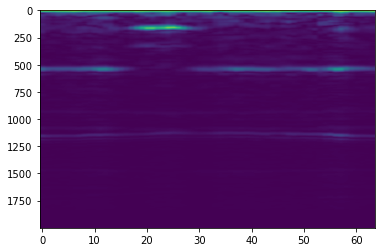

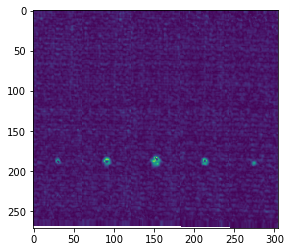

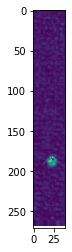

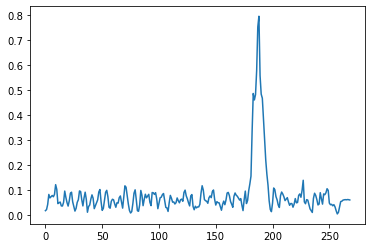

In [4]:
plt.figure()
plt.imshow(data[190,:,130:130+64], aspect='auto')
plt.show()

plt.figure()
plt.imshow(data[:,150,:])
plt.show()

plt.figure()
plt.imshow(data[:,150,130:170])
plt.show()

plt.figure()
plt.plot(data[:,150,150])
plt.show()

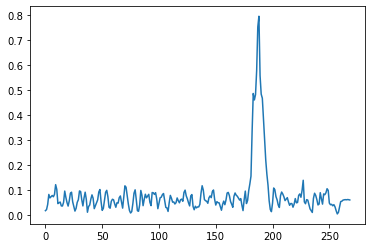

In [5]:
test=np.copy(data[:,150,150])

plt.plot(test)

threshold=150
prediction=np.zeros(np.shape(test))
errors=np.zeros(np.shape(test))
for i in range(0, prediction.size-1):
    current_pred=test[i]
    target=test[i+1]
    error=get_error(current_pred, target)
    errors[i+1]=error
    if error>threshold:
        prediction[i+1]=1
        test[i+1]=current_pred

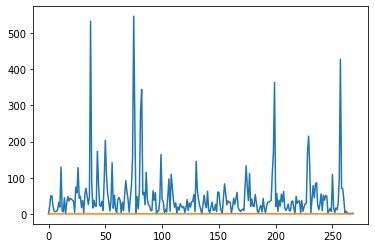

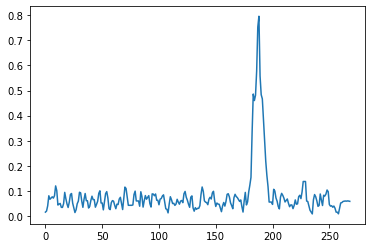

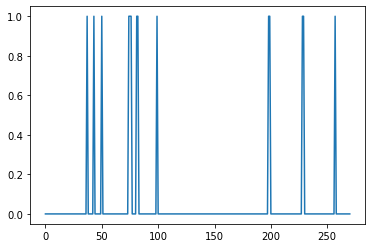

In [6]:
plt.figure()
plt.plot(errors)
plt.plot(test)
plt.show()

plt.figure()
plt.plot(test)
plt.show()

plt.figure()
plt.plot(prediction)
plt.show()

# test model

In [7]:
import numpy as np
import itertools
import time
import datetime
import math
from pathlib import Path
import os

import torchvision.transforms as transforms
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torchvision.utils import make_grid
import torch.nn.functional as F
import torch
from torchinfo import summary
from torch.utils.data import Dataset


C:\Users\Shaun McKnight\anaconda3\envs\torch_phd\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
class CleanDataset(Dataset):
    def __init__(self, data, transforms_=None):
        self.transform = transforms.Compose(transforms_)
        
        self.id007=data
            
        print('~~~~ Synthetic dataloader INFO ~~~~~')
        print('Number points train ~ ', 'Max/Min ', np.amax(self.id007), np.amin(self.id007))
        #length 500 time series
              
    def __getitem__(self, index):       
        base_data=self.id007[index:index+65]
        
        data = base_data[:64]
        label = base_data[64]   
        
        return torch.from_numpy(np.copy(data)).unsqueeze(0), torch.from_numpy(np.copy(label)).unsqueeze(0)
        #At least one stride in the given numpy array is negative, and tensors with negative strides are not currently supported. (You can probably work around this by making a copy of your array  with array.copy().) 

    def __len__(self):
        return self.id007.size-65

In [ ]:
def validation(
    dataloader,
    Tensor,
    Net,
):
    targets = []
    predictions = []
    priors = []
    # TRAINING
    prev_time = time.time()
    Net.eval()
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            data, labels = batch
            data.type(Tensor)
            labels.type(Tensor)
            
            if torch.cuda.is_available():
                data = data.cuda()
                labels = labels.cuda()

            # forward + backward + optimize
            outputs = Net(data)
            
            [targets.append(labels[i].cpu().numpy()) for i in range(
                len(labels.squeeze().cpu().numpy()))]
            
            [predictions.append(outputs[i].cpu().numpy()) for i in range(
                len(outputs.squeeze().cpu().numpy()))]
            
            # [print(data[i][-1].shape) for i in range(
            #     len(outputs.squeeze().cpu().numpy()))]
            [priors.append(data[i][-1][-1].cpu().numpy()) for i in range(
                len(outputs.squeeze().cpu().numpy()))]
            
#             plt.figure()
#             plt.plot(data[i].cpu().numpy())
#             plt.plot(test[i:64])

    errors_percent=get_error(np.squeeze(predictions), np.squeeze(targets))
    errors_priors=get_error(np.squeeze(priors), np.squeeze(targets))
    print('Finished Validation')
    return errors_percent, errors_priors, targets, predictions

In [9]:
def validation2(
    test_data,
    Tensor,
    Net,
    threshold=6
):
    predictions = np.zeros(test_data.shape)
    segmented = np.zeros(test_data.shape)
    errors = np.zeros(test_data.shape)
    
    test_mapped=np.copy(test_data)
    prediction_mapped=[]
    
    prev_time = time.time()
    Net.eval()
    
    threshold=np.full(test_mapped.shape[0], threshold)
    with torch.no_grad():
        for i in range(0,test_mapped.shape[1]-65):
            batch=torch.from_numpy(np.expand_dims(test_mapped[:,i:i+64],1))
            targets=np.squeeze(test_mapped[:,i+64])
               
            if torch.cuda.is_available():
                batch = batch.cuda()

            prediction = Net(batch).cpu().numpy().squeeze()
                
            error = get_error(prediction, targets)
                
            mask=error>threshold 
            test_mapped[:,i+64][mask]=prediction[mask]# check these are working
            segmented[:,i+64]=mask
            predictions[:,i+64]=prediction
            errors[:,i+64]=error
    
#     plt.figure()
#     plt.imshow(test_data)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(test_mapped)
#     plt.show()
    
#     plt.figure()
#     plt.imshow(errors)
#     plt.show()

#     plt.figure()
#     plt.imshow(segmented)
#     plt.show()


    print('Finished Validation, inference time: ', time.time() - prev_time)
    return errors, segmented, predictions, test_mapped

In [670]:
def validation3(
    test_data,
    Tensor,
    Net,
    threshold=6
):
    predictions = np.zeros(test_data.shape)
    segmented = np.zeros(test_data.shape)
    errors = np.zeros(test_data.shape)
    
    test_mapped=np.copy(test_data)
    prediction_mapped=[]
    
    prev_time = time.time()
    Net.eval()
    
    with torch.no_grad():
        for j in range(0,test_mapped.shape[0]):
            for i in range(100,test_mapped.shape[1]-65):
                # print(test_mapped[j,i:i+64]==test_data[j,i:i+64])
                input_data=test_mapped[j,i:i+64]
                target=test_mapped[j,i+64]

                input_data = torch.from_numpy(input_data).unsqueeze(0).unsqueeze(0)
                
                if torch.cuda.is_available():
                    input_data = input_data.cuda()
                    

                prediction = Net(input_data)
                prediction = prediction.cpu().numpy()
                
                error = get_error(prediction, target)
            
                if error>threshold:
                    predictions[j,i+64]=1
                    test_mapped[j,i+64]=prediction
                else:
                    predictions[j,i+64]=0

                errors[j,i+64]=error
                
                # print(error)
                # plt.figure()
                # plt.plot(np.squeeze(np.squeeze(input_data.cpu().numpy())))
                # plt.plot(test_mapped[j,i:i+64])
                # plt.scatter(64, prediction)
                # plt.scatter(64, target, marker='x')
                # plt.ylim(1,2)
                # plt.xlim(50)
                # plt.show()

    
    plt.figure()
    plt.imshow(test_data)
    plt.show()
    
    plt.figure()
    plt.imshow(test_mapped)
    plt.show()
    
    plt.figure()
    plt.imshow(errors)
    plt.show()

    plt.figure()
    plt.imshow(predictions)
    plt.show()


    print('Finished Validation, inference time: ', time.time() - prev_time)
    return errors, segmented, predictions, test_mapped

test=data[:,150,130:170]
print(test.shape)
errors, segmented, predictions, mapped_data = validation3(
        np.swapaxes(test+1,0,1),#[20:23,:], #need d axes at the end
        Tensor=Tensor,
        Net=top_model,
        threshold=8.69#7.53
    )

(271, 40)
Finished Validation, inference time:  9.891191720962524


In [ ]:
#data loader
test_dataloader = DataLoader(
        CleanDataset(test, transforms_ = True),
        batch_size=2,
        shuffle=False,
        # num_workers=1,
)

In [11]:
model_path = 'C:/GIT/Self-supervised-volumetric-detection/saved_models/exp_3/best_model_epoch_864_model.pt' #209 is model w/o adjustment up
top_model = torch.load(model_path)

cuda = True if torch.cuda.is_available() else False
Tensor = torch.cuda.FloatTensor if cuda else torch.Tensor

In [ ]:
errors_percent, errors_priors, targets, prediction = validation(
        dataloader=test_dataloader,
        Tensor=Tensor,
        Net=top_model,
    )

In [600]:
test=data[:,150,130:170]
print(test.shape)
errors, segmented, predictions, mapped_data = validation2(
        np.swapaxes(test+1,0,1),#[20:23,:], #need d axes at the end
        Tensor=Tensor,
        Net=top_model,
        threshold=8.69#7.53
    )

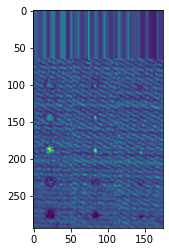

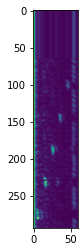

In [22]:
test=data[20:250,0:600:10,130:]
test=np.pad(test,((64,0),(0,0),(0,0)),'edge')
plt.figure()
plt.imshow(np.amax(test[:,20:,:],1))
plt.show()

plt.figure()
plt.imshow(test[:,:,23])
plt.show()

In [25]:
#for volume
# test=data[:,0:600:10,130:170]
segmented_volume=np.zeros(test.shape)
errors_total=np.zeros(test.shape)
for i in range(0,segmented_volume.shape[1]):
    print(i)
    test_slice=test[:,i,:]
    errors, segmented, predictions, mapped_data = validation2(
            np.swapaxes(test_slice+1,0,1),#[20:23,:], #need d axes at the end
            Tensor=Tensor,
            Net=top_model,
            threshold=8.69#7.53
        )
    segmented_volume[:,i,:]=np.swapaxes(segmented, 0,1)
    errors_total[:,i,:]=np.swapaxes(errors, 0,1)

0
Finished Validation, inference time:  2.0846683979034424
1
Finished Validation, inference time:  1.7956328392028809
2
Finished Validation, inference time:  1.795408010482788
3
Finished Validation, inference time:  1.798624038696289
4
Finished Validation, inference time:  1.8022665977478027
5
Finished Validation, inference time:  1.7992875576019287
6
Finished Validation, inference time:  1.8094205856323242
7
Finished Validation, inference time:  1.802821159362793
8
Finished Validation, inference time:  1.7961418628692627
9
Finished Validation, inference time:  1.7987372875213623
10
Finished Validation, inference time:  1.8038921356201172
11
Finished Validation, inference time:  1.8022143840789795
12
Finished Validation, inference time:  1.8041448593139648
13
Finished Validation, inference time:  1.8081934452056885
14
Finished Validation, inference time:  1.8109586238861084
15
Finished Validation, inference time:  1.8176162242889404
16
Finished Validation, inference time:  1.8228988647

In [29]:
np.save('segmented_volume',segmented_volume)

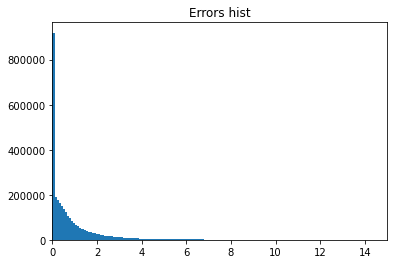

In [28]:
plt.figure()
plt.title('Errors hist')
plt.hist(errors_total.flatten(), bins=1000)
plt.xlim(0,15)
plt.show()

(271, 2000, 305)


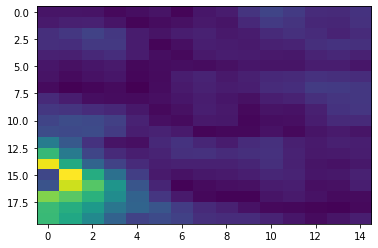

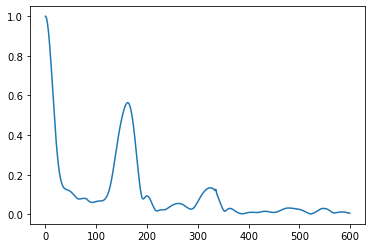

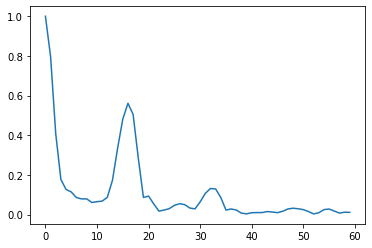

In [665]:
print(data.shape)
plt.figure()
plt.imshow(data[170:190,150,155:170], aspect='auto')

plt.figure()
plt.plot(data[185,:600,150])
plt.figure()

plt.plot(data[185,0:600:10,150])
# plt.plot(data[190,:,24])
# plt.plot(data[182,:,24])

0.8287153911061913 3.851947715606111e+71 nan
0.0 3.5901263415424646e+73 3.561626731528074e+69
(40, 271)


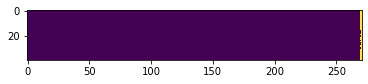

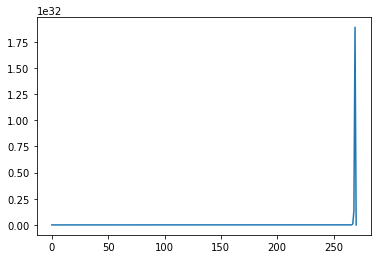

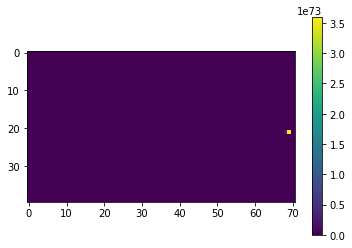

In [ ]:
print(np.nanmin(mapped_data), np.nanmax(mapped_data), np.mean(mapped_data))
print(np.amin(errors), np.amax(errors), np.mean(errors))
print(errors.shape)

nan_mask = np.isnan(mapped_data)

# Create a plot showing NaN locations as a heatmap
plt.imshow(nan_mask, cmap='viridis', interpolation='nearest')

plt.figure()
plt.plot(errors[20,])

plt.figure()
plt.imshow(errors[:,200:])
plt.colorbar()

(40, 271)


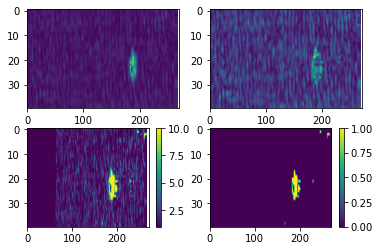

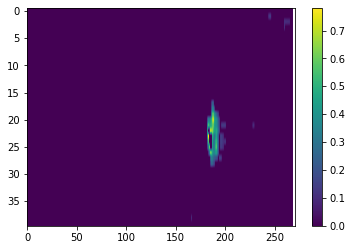

In [666]:
print(segmented.shape)
fig = plt.figure()

plt.subplot(2, 2, 1)
plt.imshow(np.swapaxes(test+1,0,1), aspect='auto')

plt.subplot(2, 2, 2)
plt.imshow(np.clip(mapped_data, 1,2), aspect='auto')

plt.subplot(2, 2, 3)
plt.imshow(np.clip(errors, 1,10), aspect='auto')
plt.colorbar()

plt.subplot(2, 2, 4)
plt.imshow(segmented, aspect='auto')
plt.colorbar()

plt.figure()
plt.imshow(abs(np.swapaxes(test+1,0,1)-np.clip(mapped_data, 1,5)), aspect='auto')
plt.colorbar()

(40, 271)


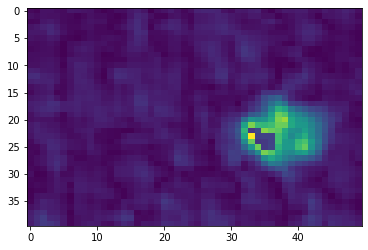

In [625]:
plot = np.swapaxes(test+1,0,1)
print(plot.shape)
plt.figure()
plt.imshow(plot[:,150:200], aspect='auto')

plt.figure()
plt.plot(test[])